# Test simple du modèle ResNet50


In [1]:
import sys
import torch
import torch.nn.functional as F
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
import numpy as np

sys.path.append('../src/features')
from model_utils import load_model
from training_config import *

print("Imports OK")


Imports OK


In [11]:
# Charger le modèle
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
checkpoint_path = Path('../models/') / MODEL_CHECKPOINT_PATH

model = load_model(
    model_choice=MODEL_CHOICE,
    num_classes=NUM_CLASSES,
    checkpoint_path=checkpoint_path,
    device=device,
    transfer_mode=TRANSFER_MODE,
)
model.eval()
print("Modele charge")


  Mode: Fine-tuning sélectif (couches gelées: ['conv1', 'bn1', 'layer1'])

 Modèle resnet50 créé
   Paramètres totaux: 23,505,858
   Paramètres entraînables: 18,987,010 (80.8%)
   Paramètres gelés: 4,518,848 (19.2%)
 Format détecté: state_dict direct
 Modèle chargé depuis '../models/best_model_resnet50-marouane.pth'
 Modèle déplacé sur mps
   Paramètres totaux: 23,505,858
   Paramètres entraînables: 18,987,010
Modele charge


In [3]:
# Fonction simple pour prédire une image
def predict(image_path):
    # Charger et préprocesser l'image
    img = Image.open(image_path).convert('L').resize((299, 299))
    img_array = np.array(img, dtype=np.float32) / 255.0
    img_tensor = torch.from_numpy(img_array).unsqueeze(0).unsqueeze(0).float()
    img_tensor = transforms.Normalize(mean=[0.5], std=[0.5])(img_tensor)
    img_tensor = img_tensor.to(device)
    
    # Prédiction
    with torch.no_grad():
        outputs = model(img_tensor)
        probs = F.softmax(outputs, dim=1)[0].cpu().numpy()
    
    if BINARY_CLASSIFICATION:
        return 'COVID' if probs[1] > 0.5 else 'Non-COVID', probs[1] if probs[1] > 0.5 else probs[0]
    else:
        classes = CLASSES
        idx = np.argmax(probs)
        return classes[idx], probs[idx]




## Test sur une image

Pour sélectionner une image aléatoirement d'un dossier, utilisez:
```python
import random
images = list((DATASET_ROOT / 'COVID').glob('*.png'))
image_path = random.choice(images)
```


Image selectionnee: Lung_Opacity-3439.png (classe: Lung_Opacity)


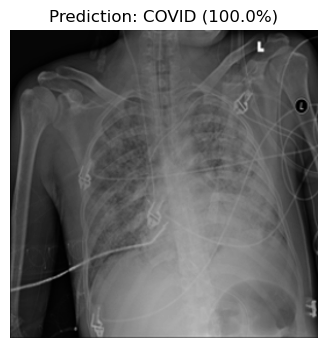

Prediction: COVID
Confiance: 100.0%


In [25]:
# Sélectionner une image aléatoirement
import random

# Choisir une classe
test_class = 'Lung_Opacity'  # Changer pour 'Normal', 'Lung_Opacity', 'Viral Pneumonia'

# Obtenir toutes les images du dossier
images = list((DATASET_ROOT / test_class / "images").glob('*.png'))

# Sélectionner une image aléatoirement
image_path = random.choice(images)

print(f"Image selectionnee: {image_path.name} (classe: {test_class})")

# Prédiction
prediction, confidence = predict(image_path)

# Afficher
img = Image.open(image_path).convert('L')
plt.figure(figsize=(8, 4))
plt.imshow(img, cmap='gray')
plt.title(f'Prediction: {prediction} ({confidence:.1%})')
plt.axis('off')
plt.show()

print(f"Prediction: {prediction}")
print(f"Confiance: {confidence:.1%}")


In [23]:
# Test sur plusieurs images
test_class = 'COVID'  # Changer si besoin
images = list((DATASET_ROOT / test_class / "images").glob('*.png'))[:5]

correct = 0
for img_path in images:
    pred, conf = predict(img_path)
    true_class = 'COVID' if test_class == 'COVID' else 'Non-COVID'
    is_correct = (pred == true_class)
    if is_correct:
        correct += 1
    status = "OK" if is_correct else "ERREUR"
    print(f"{status} {img_path.name}: {pred} ({conf:.1%})")

print(f"\nPrecision: {correct}/{len(images)} = {correct/len(images):.1%}")


OK COVID-1.png: COVID (100.0%)
OK COVID-1175.png: COVID (100.0%)
OK COVID-1613.png: COVID (100.0%)
OK COVID-948.png: COVID (100.0%)
OK COVID-790.png: COVID (100.0%)

Precision: 5/5 = 100.0%
